# Borja Ruiz Amantegui
# Homework 3: Classifying Cars & Trucks with SVMs.

------------------------------------------------------
*Machine Learning, Master in Big Data Analytics, 2017-2018*

*Pablo M. Olmos olmos@tsc.uc3m.es*

------------------------------------------------------

In this homework you will work with [CIFAR-10](http://www.cs.utoronto.ca/%7Ekriz/cifar.html), a database of natural images that belong to 10 different categories.

<img src="plot_cifar.png" alt="Drawing" style="width: 500px;"/>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

In this homework, using data from a single training batch, we will classify between **cars & trucks**.  You are encouraged  to try later some other classification problems.

Lets load the libraries that we will use

In [2]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from scipy import stats
from time import time
import os,glob,numpy
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics
import itertools
import os, sys
from sklearn.svm import SVC # "Support vector classifier"
from sklearn.metrics import accuracy_score #cccuracy_score metric


# use seaborn plotting defaults
import seaborn as sns; sns.set()

%matplotlib inline

## Loading the dataset

Download the database from [here](http://www.cs.utoronto.ca/%7Ekriz/cifar-10-python.tar.gz) and unzip the file in the same folder where you are running the notebook.

Following the [instructions](http://www.cs.utoronto.ca/%7Ekriz/cifar.html), this is how you can load a batch of training data and the one for test.-

In [3]:
def unpickle(file):
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

# We use a portion of CIFAR. Batch 1 contains 10^4 image samples of 10 categories
dat = unpickle('./cifar-10-batches-py/data_batch_1')
# Test data
dat_test = unpickle('./cifar-10-batches-py/test_batch')

labels = np.array(dat[b'labels'])
images = dat[b'data']

labels_test =np.array(dat_test[b'labels'])
images_test = dat_test[b'data']

Now, we reduce the data set to only two categories. Cars (label = 1), and trucks (label = 9)

In [4]:
index_1 = 1
index_2 = 9

labels_red = labels[(labels == index_1) + (labels ==index_2)]
images_red = images[(labels == index_1) + (labels ==index_2),:]

labels_red_test = labels_test[(labels_test == index_1) + (labels_test ==index_2)]
images_red_test = images_test[(labels_test == index_1) + (labels_test ==index_2),:]

print('There are %d train images of cars and %d train images of trucks' %(np.sum(labels_red==index_1),np.sum(labels_red==index_2)))

There are 974 train images of cars and 981 train images of trucks


Lets plot some of the train images. The only tricky point is that we have to reshape the image in Red, Green, and Blue channels.

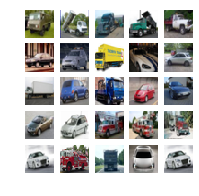

In [5]:
X = images_red.reshape(-1, 3, 32, 32).transpose(0,2,3,1)

#Visualizing CIFAR 10
fig, axes1 = plt.subplots(5,5,figsize=(3,3))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X[i:i+1][0])
        

## 1. Data normalization

Before running the SVM, it is always desirable to normalize our training data so each feature has zero sample mean and unit variance.

** Question 1 (1 point) **

Normalize your training and test data using the training **sample mean and std**.

In [6]:
# A function that normalizes data with pre-scecified mean and std. 
def normalize(X,mu=0,std=1,flag_train=True):
    if(flag_train):
        mu = np.mean(X,0)
        std = np.std(X,0)
    
    X -= mu
    X /= std
    
    return X,mu,std


img_norm, mu, std = normalize(images_red.astype(np.float64),mu=0,std=1,flag_train=True)

img_test_norm,_,_ = normalize(images_red_test.astype(np.float64),mu,std,flag_train=False)


# 2. Training a Gaussian RBF SVC

** Question 2 (3 points) ** 

* Apply a 5-times cross validation to estimate the missclasification rate varying C from .01 to 100 (in log scale) with $\gamma$ equal to 1.
* Apply a 5-times cross validation to estimate the missclasification rate varying $\gamma$ from .01 to 10 (in log scale) and the best C obtained in the previous step
* Apply a 5-times cross validation to estimate the missclasification rate varying C and $\gamma$ around the best values obtained previously in steps 2x.

On the whole train data set:
* Train a single SVC with the best C and $\gamma$
* Evaluate the missclasification rate with the trained classifier
* **Check the number of suppor vectors**

On the test data set:
* Evaluate the missclasification rate with the trained classifier
* Try to plot to missclasified images and some correctly classified

Check [here](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) to see how to use sklearn to easily obtain train/validation partitions for k-fold cross validation.

## 2.1 Varying C

In [76]:
cValues = [pow(10, i) for i in range(-2,3)]

In [6]:
def CrossValidationC(C, times):
    errors = []
    kf = ShuffleSplit(n_splits=times, test_size=0.3, random_state=None)
    for C in C:
        errorsInCross = []
        for train_index, test_index in kf.split(X):
            model = SVC(kernel='rbf', gamma=1, C=C)
            #Training
            model.fit(img_norm[train_index], labels_red[train_index])
            #Testing
            y_predict = model.predict(img_norm[test_index])
            errorsInCross.append(1-accuracy_score(labels_red[test_index], y_predict))
        errors.append(np.mean(errorsInCross))
    return errors

In [20]:
x = CrossValidationC(cValues, 5)

In [21]:
bestC = cValues[x.index(min(x))]

## 2.2 Varying $\gamma$

In [26]:
gammaValues = [pow(10, i) for i in range(-2,1)]

In [27]:
def CrossValidationGamma(C, times, gamma):
    errors = []
    kf = ShuffleSplit(n_splits=times, test_size=0.3, random_state=None)
    for gamma in gamma:
        errorsInCross = []
        for train_index, test_index in kf.split(X):
                model = SVC(kernel='rbf', gamma=gamma, C=C)
                #Training
                model.fit(img_norm[train_index], labels_red[train_index])
                #Testing
                y_predict = model.predict(img_norm[test_index])
                errorsInCross.append(1-accuracy_score(labels_red[test_index], y_predict))
        errors.append(np.mean(errorsInCross))
    return errors

In [28]:
m = CrossValidationGamma(bestC, 5, gammaValues)

In [29]:
bestGamma = gammaValues[m.index(min(m))]

## 2.3 Best values error compute

In [34]:
print("Best value for C is: " + str(bestC) + " and for gamma is: " + str(bestGamma))

Best value for C is: 100 and for gamma is: 0.01


In [45]:
bestcValues = [90,95,100,105,110]
bestgValues = [0.005,0.01,0.015,0.02]

In [63]:
def bestFit(Cv, Gv, times):
    errors = np.zeros([len(Cv),len(Gv)])
    kf = ShuffleSplit(n_splits=times, test_size=0.3, random_state=None)
    for indexc, c in enumerate(Cv):
        for indexg, g in enumerate(Gv):
            errorsInCross = []
            for train_index, test_index in kf.split(X):
                model = SVC(kernel='rbf', gamma=g, C=c)
                #Training
                model.fit(img_norm[train_index], labels_red[train_index])
                #Testing
                y_predict = model.predict(img_norm[test_index])
                errorsInCross.append(1-accuracy_score(labels_red[test_index], y_predict))
            errors[indexc,indexg] = np.mean(errorsInCross)
    return errors

In [64]:
b = bestFit(bestcValues, bestgValues, 5)

In [65]:
b

array([[ 0.50834753,  0.50255537,  0.50834753,  0.51482112],
       [ 0.47529813,  0.51584327,  0.51073254,  0.52061329],
       [ 0.52367973,  0.51822828,  0.50630324,  0.50732538],
       [ 0.50834753,  0.50971039,  0.51005111,  0.5120954 ],
       [ 0.51243612,  0.50800681,  0.50868825,  0.51686542]])

Best value for C is 95 and best value for gamma 0.005

## 2.4 Whole dataset

In [136]:
model = SVC(kernel='rbf', gamma=0.005, C=95)
#Training
model.fit(img_norm, labels_red)

SVC(C=95, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [137]:
y_predict = model.predict(img_test_norm)
1-accuracy_score(labels_red_test, y_predict)

0.49050000000000005

In [138]:
len(model.support_vectors_)

1955

## 2.5 Printing classified images

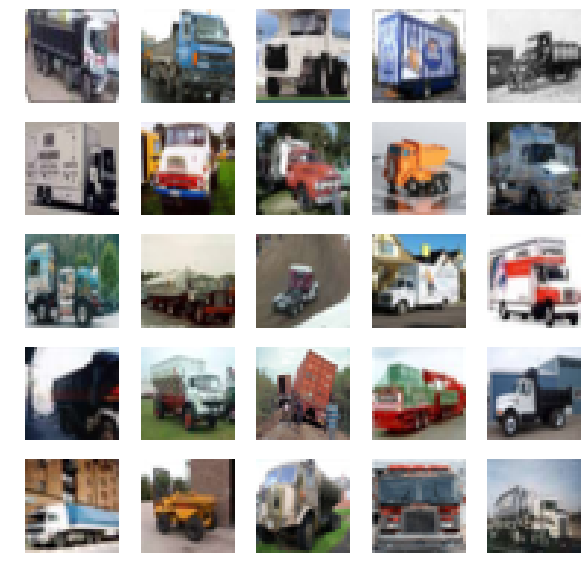

In [160]:
correct1 = labels_red_test == y_predict
goodImages = images_red_test[correct1]

X_g = goodImages.reshape(-1, 3, 32, 32).transpose(0,2,3,1)

#Visualizing CIFAR 10
fig, axes1 = plt.subplots(5,5,figsize=(10,10))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X_g)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X_g[i:i+1][0])

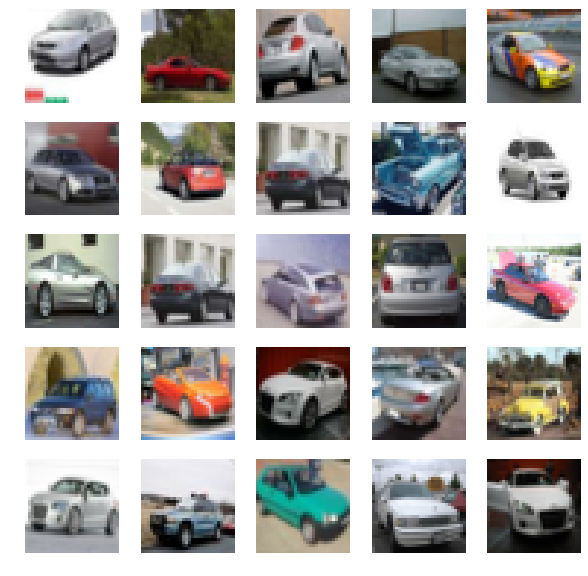

In [161]:
wrong1 = labels_red_test != y_predict
badImages = images_red_test[wrong1]

X_b = badImages.reshape(-1, 3, 32, 32).transpose(0,2,3,1)

#Visualizing CIFAR 10
fig, axes1 = plt.subplots(5,5,figsize=(10,10))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X_b)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X_b[i:i+1][0])

## 3. Training a Gaussian Polynomial SVC

** Question 3 (3 points) ** 

Set $\gamma=1$ in the polynomial kernel and then 
* Apply a 5-times cross validation to estimate the missclasification rate varying C from .01 to 100 (in log scale) with degree equal to 3.
* Apply a 5-times cross validation to estimate the missclasification rate varying degree from 1 (linear) to 5 and the best C obtained in the previous step.
* Apply a 5-times cross validation to estimate the missclasification rate using the best degree and varying C around the best value obtained previously in steps 2x.

On the whole train data set:
* Train a single SVC with the best C and degree

* Evaluate the missclasification rate with the trained classifier
* **Check the number of suppor vectors**

On the test data set:
* Evaluate the missclasification rate with the trained classifier
* Try to plot to missclasified images and some correctly classified

Check [here](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) to see how to use sklearn to easily obtain train/validation partitions for k-fold cross validation.

## 3.1 Varying C in polynomial SVC

In [70]:
#Your code here
def CrossValidationCPoly(C, times):
    errors = []
    kf = ShuffleSplit(n_splits=times, test_size=0.3, random_state=None)
    for C in C:
        errorsInCross = []
        for train_index, test_index in kf.split(X):
                model = SVC(kernel='poly', gamma=1, C=C, degree=3) 
                #Training
                model.fit(img_norm[train_index], labels_red[train_index])
                #Testing
                y_predict = model.predict(img_norm[test_index])
                errorsInCross.append(1-accuracy_score(labels_red[test_index], y_predict))
        errors.append(np.mean(errorsInCross))
    return errors

In [78]:
a = CrossValidationCPoly(cValues, 5)

In [79]:
cValues

[0.01, 0.1, 1, 10, 100]

In [80]:
bestC = cValues[a.index(min(a))]

In [81]:
bestC

100

## 3.2 Varying degree in polynomial SVC

In [99]:
def CrossValidationGammaPoly(C, times, degree):
    errors = []
    kf = ShuffleSplit(n_splits=times, test_size=0.3, random_state=None)
    for deg in degree:
        errorsInCross = []
        for train_index, test_index in kf.split(X):
                model = SVC(kernel='poly', gamma=1, C=C, degree=deg) 
                #Training
                model.fit(img_norm[train_index], labels_red[train_index])
                #Testing
                y_predict = model.predict(img_norm[test_index])
                errorsInCross.append(1-accuracy_score(labels_red[test_index], y_predict))
        errors.append(np.mean(errorsInCross))
    return errors

In [101]:
u = CrossValidationGammaPoly(bestC, 5, range(1,5))

In [103]:
bestDegree = u.index(min(u))

## 3.3 Obtaining best model

In [105]:
print(bestC)

100


In [106]:
bestcValues = [90,95,100,105,110]

In [109]:
def crossValidationCPolyWithDeg(C, times, deg):
    errors = []
    kf = ShuffleSplit(n_splits=times, test_size=0.3, random_state=None)
    for c in C:
        errorsInCross = []
        for train_index, test_index in kf.split(X):
                model = SVC(kernel='poly', gamma=1, C=c, degree=deg) 
                #Training
                model.fit(img_norm[train_index], labels_red[train_index])
                #Testing
                y_predict = model.predict(img_norm[test_index])
                errorsInCross.append(1-accuracy_score(labels_red[test_index], y_predict))
        errors.append(np.mean(errorsInCross))
    return errors

In [110]:
w = crossValidationCPolyWithDeg(bestcValues, 5, bestDegree)

In [112]:
bestC = cValues[a.index(min(a))]

In [113]:
bestC

100

## 3.4 Whole dataset

In [162]:
model = SVC(kernel='poly', gamma=1, C=100, degree=bestDegree)
#Training
model.fit(img_norm, labels_red)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma=1, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [163]:
y_predict = model.predict(img_test_norm)
1-accuracy_score(labels_red_test, y_predict)

0.35250000000000004

In [164]:
len(model.support_vectors_)

1573

## 3.5 Printing classified images

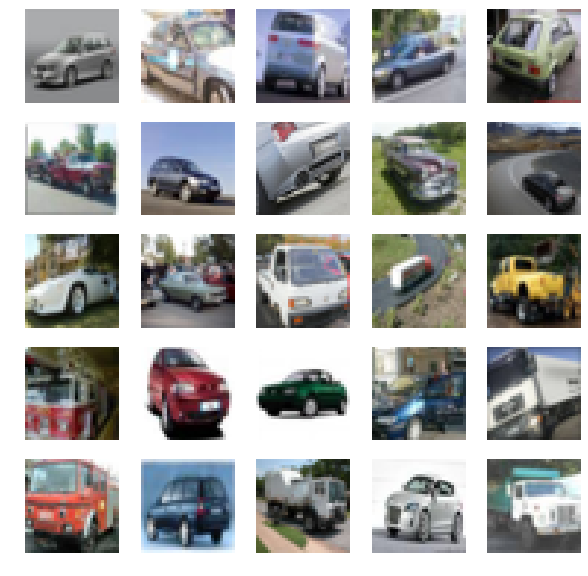

In [165]:
correct2 = labels_red_test != y_predict
goodImages = images_red_test[correct2]

X_g = goodImages.reshape(-1, 3, 32, 32).transpose(0,2,3,1)

#Visualizing CIFAR 10
fig, axes1 = plt.subplots(5,5,figsize=(10,10))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X_g)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X_g[i:i+1][0])

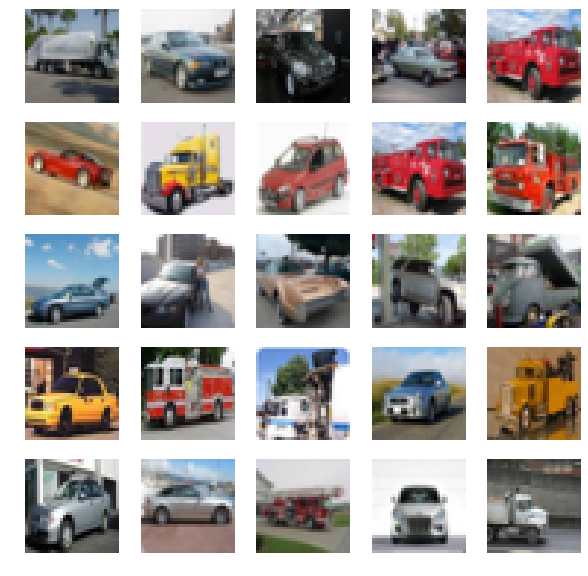

In [166]:
wrong2 = labels_red_test != y_predict
badImages = images_red_test[wrong2]

X_b = badImages.reshape(-1, 3, 32, 32).transpose(0,2,3,1)

#Visualizing CIFAR 10
fig, axes1 = plt.subplots(5,5,figsize=(10,10))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X_b)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X_b[i:i+1][0])

## 4. Doing some feature engineering

So far, you have essentially run your classifier without no feature engineering at all. While this may work, it is not a good idea in general.

** Question 4 (3 points) **

For each category, plot the mean of each features and try to understand if there are subsets of features (or new ones that could be created) where both categories can be separated away in a more effective way. If so, implement the SVC with the new set of features and evaluate the performance compared to the models you run before.

For instance, if we were comparing dogs & frogs, I would expect that the green levels in frog images would be higher than in dogs images.

**Note** There is no closed solution to this. I just want to make you think about your data ... 

Text(0.5,1,u'Pixel Std in Train Set')

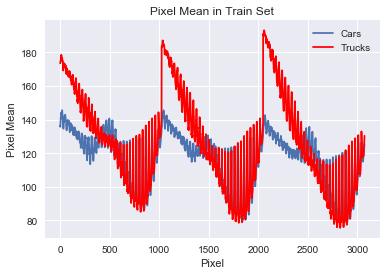

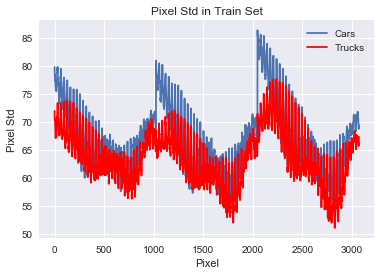

In [9]:
#The following code plots the pixel mean and std for images in each class

plt.plot(np.mean(images_red[labels_red==index_1,:],0),label='Cars')
plt.plot(np.mean(images_red[labels_red==index_2,:],0),'r',label='Trucks')
plt.legend()
plt.xlabel('Pixel')
plt.ylabel('Pixel Mean')
plt.title('Pixel Mean in Train Set')

plt.figure()
plt.plot(np.std(images_red[labels_red==index_1,:],0),label='Cars')
plt.plot(np.std(images_red[labels_red==index_2,:],0),'r',label='Trucks')
plt.legend()
plt.xlabel('Pixel')
plt.ylabel('Pixel Std')
plt.title('Pixel Std in Train Set')


## Adding new features

We first create two new variables for each image, to indicate if the mean is higher than 145 and the std higher than 77 since this are two differentiator features from trucks and cars. 

In [7]:
N = np.zeros((1955, 3074))
N_test = np.zeros((2000,3074))
N[:,:-2] = images_red
N_test[:,:-2] = images_red_test

In [8]:
for index,i in enumerate(N[:,]):
        if np.mean(i) >= 145:
            N[index,-2] = 1

In [9]:
for index,i in enumerate(N[:,]):
        if np.std(i) >= 77:
            N[index,-1] = 1

In [10]:
for index,i in enumerate(N_test[:,]):
        if np.mean(i) >= 145:
            N_test[index,-2] = 1

In [11]:
for index,i in enumerate(N_test[:,]):
        if np.std(i) >= 77:
            N_test[index,-1] = 1

We now normalize both variables to compute the models

In [13]:
newImage, mu, std = normalize(N.astype(np.float64),mu=0,std=1,flag_train=True)
newImage_test, _, _ = normalize(N_test.astype(np.float64),mu=0,std=1,flag_train=True)

### RBF 

In [17]:
model = SVC(kernel='rbf', gamma=0.005, C=95)
#Training
model.fit(newImage, labels_red)

SVC(C=95, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [18]:
new_predict = model.predict(newImage_test)
1-accuracy_score(labels_red_test, new_predict)

0.48950000000000005

In [19]:
len(model.support_vectors_)

1955

For the rbf kernel we are able to slightly reduce the error with the new dataset.

### Polinomial kernel

In [14]:
model = SVC(kernel='poly', gamma=1, C=100, degree=2)
#Training
model.fit(newImage, labels_red)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma=1, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [15]:
new_predict = model.predict(newImage_test)
1-accuracy_score(labels_red_test, new_predict)

0.35250000000000004

In [16]:
len(model.support_vectors_)

1569

We observe that though the error is the same we have reduced by 4 the number of support vectors for the polinomial kernel.

## Eliminating features

Since we see a trend, mean is higher for trucks, in the top values of the images. We obtain for each of the colour channels the top thirds of the images.

In [20]:
A = np.zeros((1955,1200))
A[:,:400] = images_red[:,:400]
A[:,400:800] = images_red[:,1024:1424]
A[:,800:1200] = images_red[:,2024:2424]
A_test = np.zeros((2000,1200))
A_test[:,:400] = images_red_test[:,:400]
A_test[:,400:800] = images_red_test[:,1024:1424]
A_test[:,800:1200] = images_red_test[:,2024:2424]

In [21]:
newImage, mu, std = normalize(A.astype(np.float64),mu=0,std=1,flag_train=True)
newImage_test, _, _ = normalize(A_test.astype(np.float64),mu=0,std=1,flag_train=True)

### RBF kernel

In [22]:
model = SVC(kernel='rbf', gamma=0.005, C=95)
#Training
model.fit(newImage, labels_red)

SVC(C=95, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [23]:
new_predict = model.predict(newImage_test)
1-accuracy_score(labels_red_test, new_predict)

0.30500000000000005

In [24]:
len(model.support_vectors_)

1930

## For the RBD kernel we are able to reduce the error from 0.5 to 0.3 and support vectors from 1955 to 0.305!

### Polynomial kernel

In [25]:
model = SVC(kernel='poly', gamma=1, C=100, degree=2)
#Training
model.fit(newImage, labels_red)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma=1, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [26]:
new_predict = model.predict(newImage_test)
1-accuracy_score(labels_red_test, new_predict)

0.41400000000000003

In [28]:
len(model.support_vectors_)

1366

The polinomial kernel reduces the support vectors incredibly, probably due to the smaller number of observations, but the error is still higher.